# Introduction

A hospital readmission is when a patient who had been discharged from a hospital is admitted again within a specified time interval. Readmission rates have been used as an important indicator measuring the quality of a hospital. Early identification of patients with a high risk of readmission can enable healthcare providers to conduct additional investigations and possibly prevent future readmissions.

In this project, dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals was provided.It includes over 50 features representing patient and hospital outcomes. The goal is to predict if the patient readmitted to the hospital or not.

Several different machine learning classifiers were developed and evaluated for better predicting patients with high risk of readmission. The most important features that can effect readmission of patients were discussed. The major parts of this work include:
- Exploratory data analysis
- Feature Engineering
- Training and tuning hypermeters of models: Logistic Regression, K-Nearest Means, Random Forest, XGBoost
- Models evaluation
- Summary
- Future work

# 1 Import libraries and data sets

## 1.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1.2 Import data sets

In [2]:
df = pd.read_csv('diabetic_data.csv', header=0)
mapping = pd.read_csv('IDs_mapping.csv', header=0)
print(df.shape)
print(mapping.shape)

(101766, 50)
(67, 2)


# 2 Exploratory data analysis (EDA)

## 2.1 First glimpse of data

getting a basic description of the given data. The first ten rows of train and test data
were printed below.

In [3]:
# df.head(10)

In [4]:
# mapping.head(10)

There are 101766 rows and 50 columns in this dataset. Each row in the dataset describes one diabetic inpatient encounter. Each column is a feature that either representing patient or hospital outcome. Next, let's examine how many numerical features and categorical features in the dataset, respectively.

In [5]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

In [6]:
categorical_features = df.select_dtypes(include=[np.object])
categorical_features.columns

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Let's get an overview of missing values in the dataset.

In [7]:
df.isnull().sum().sum()

0

From above analysis, there is no missing value at all in the dataset. However, after read the description of each feature, we know there are definitely missing values. All the missing values were represented using '?'. Let's replace '?' with np.nan.

*'Gender'* was coded diferently for missing values. It was represented by 'Unknown/Invalid'.

In [8]:
df.replace('?',np.nan,inplace=True)
df.replace('Unknown/Invalid',np.nan,inplace=True)

missing_count = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
missing_percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
pd.concat([missing_count, missing_percentage], axis=1, keys=['missing_count','missing_percentage'])

,missing_count,missing_percentage
weight,98569,96.86
medical_specialty,49949,49.08
payer_code,40256,39.56
race,2273,2.23
diag_3,1423,1.40
diag_2,358,0.35
diag_1,21,0.02
gender,3,NaN


There are 8 features with missing values. Three of them, *'weight'*, *'medical_specialty'* and *'payer_code'*, have a proportion of missing that larger than 35%. These three features will be dropped. The the other missing values will be dealt laterly.

In [9]:
df = df.drop([ 'weight', 'medical_specialty', 'payer_code'], axis=1)

## 2.2 Drop duplicate rows and redundant features

In [10]:
df.duplicated().sum()

0

There is not duplicated rows in the both train and test datasets. Next, redundant variables
(variables that contain same value) are explored.

In [11]:
df.encounter_id.nunique() == df.shape[0]

True

In [12]:
df.columns[df.apply(lambda x: x.nunique() == 1)]

Index(['examide', 'citoglipton'], dtype='object')

The 'encounter_id' is unique for each row so that there is no duplicate rows. There are two features, *'examide'* and *'citoglipton'*", that have the same value accross all rows. These two columns along with 'encounter_id' are dropped from the dataset.

In [13]:
df = df.drop(['examide', 'citoglipton', 'encounter_id'], axis=1)

## 2.3 Exploring predicted variable - 'readmitted'
First, let's plot the predicted variable.

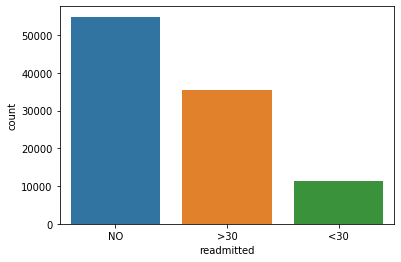

In [14]:
ax = sns.countplot(x="readmitted", data=df)

There are three different categories in the predicted variable. For most cases, there was no readmission. For the readmitted cases, most were readmitted after more than 30 days. For objective of this project is to predict if the patients were readmitted or not (binary classification). Then, *'>30'* and *'<30'* were combined as to represent that patients were readmitted.

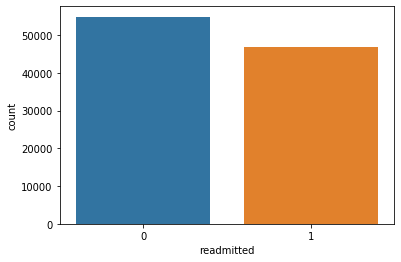

In [15]:
# '0' - no readmission; '1' - readmission
df['readmitted'] = pd.Series([0 if val == 'NO' else 1 for val in df['readmitted']])

ax = sns.countplot(x="readmitted", data=df)

Now, this problem can be treated as a binary classification. From the count plot above, we can find that non-readmitted encounters are more than readmitted cases. But they now have close counts.

## 2.4 A deep dive to features
First, the correlation between all features with predicted variable are explored. Then, different selected features are further explored.

## Numerical features

### Correlation heat map

The correlations between numerical features are shown in the following heat map. There are several features that are actually categorical and they are encoded later.

Text(0.5, 1, 'Correlations between features')

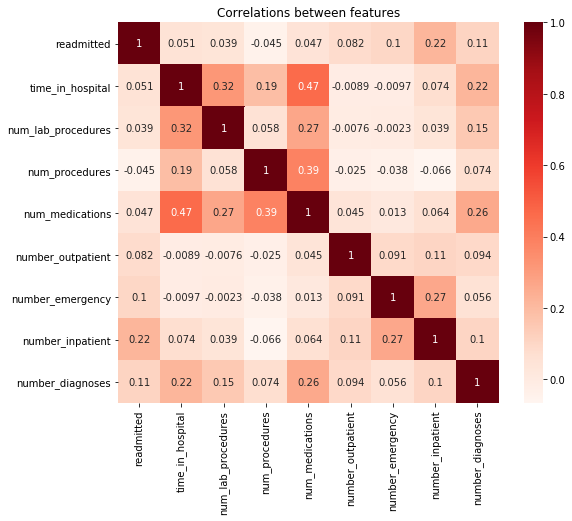

In [16]:
# correlation matrix
num_cols = ['readmitted','time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
            'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(df[num_cols].corr(),square=True,cmap='Reds',annot=True).set_title('Correlations between features')

In [17]:
cols_corr = df.corr().nlargest(5, 'readmitted').index
print(cols_corr)

Index(['readmitted', 'number_inpatient', 'number_diagnoses',
       'number_emergency', 'number_outpatient'],
      dtype='object')


There are three numerical features that have correlation coefficients larger than 0.1, *'number_inpatient'*, *'number_diagnoses'* and *'number_emergency'*.

### Pair plot

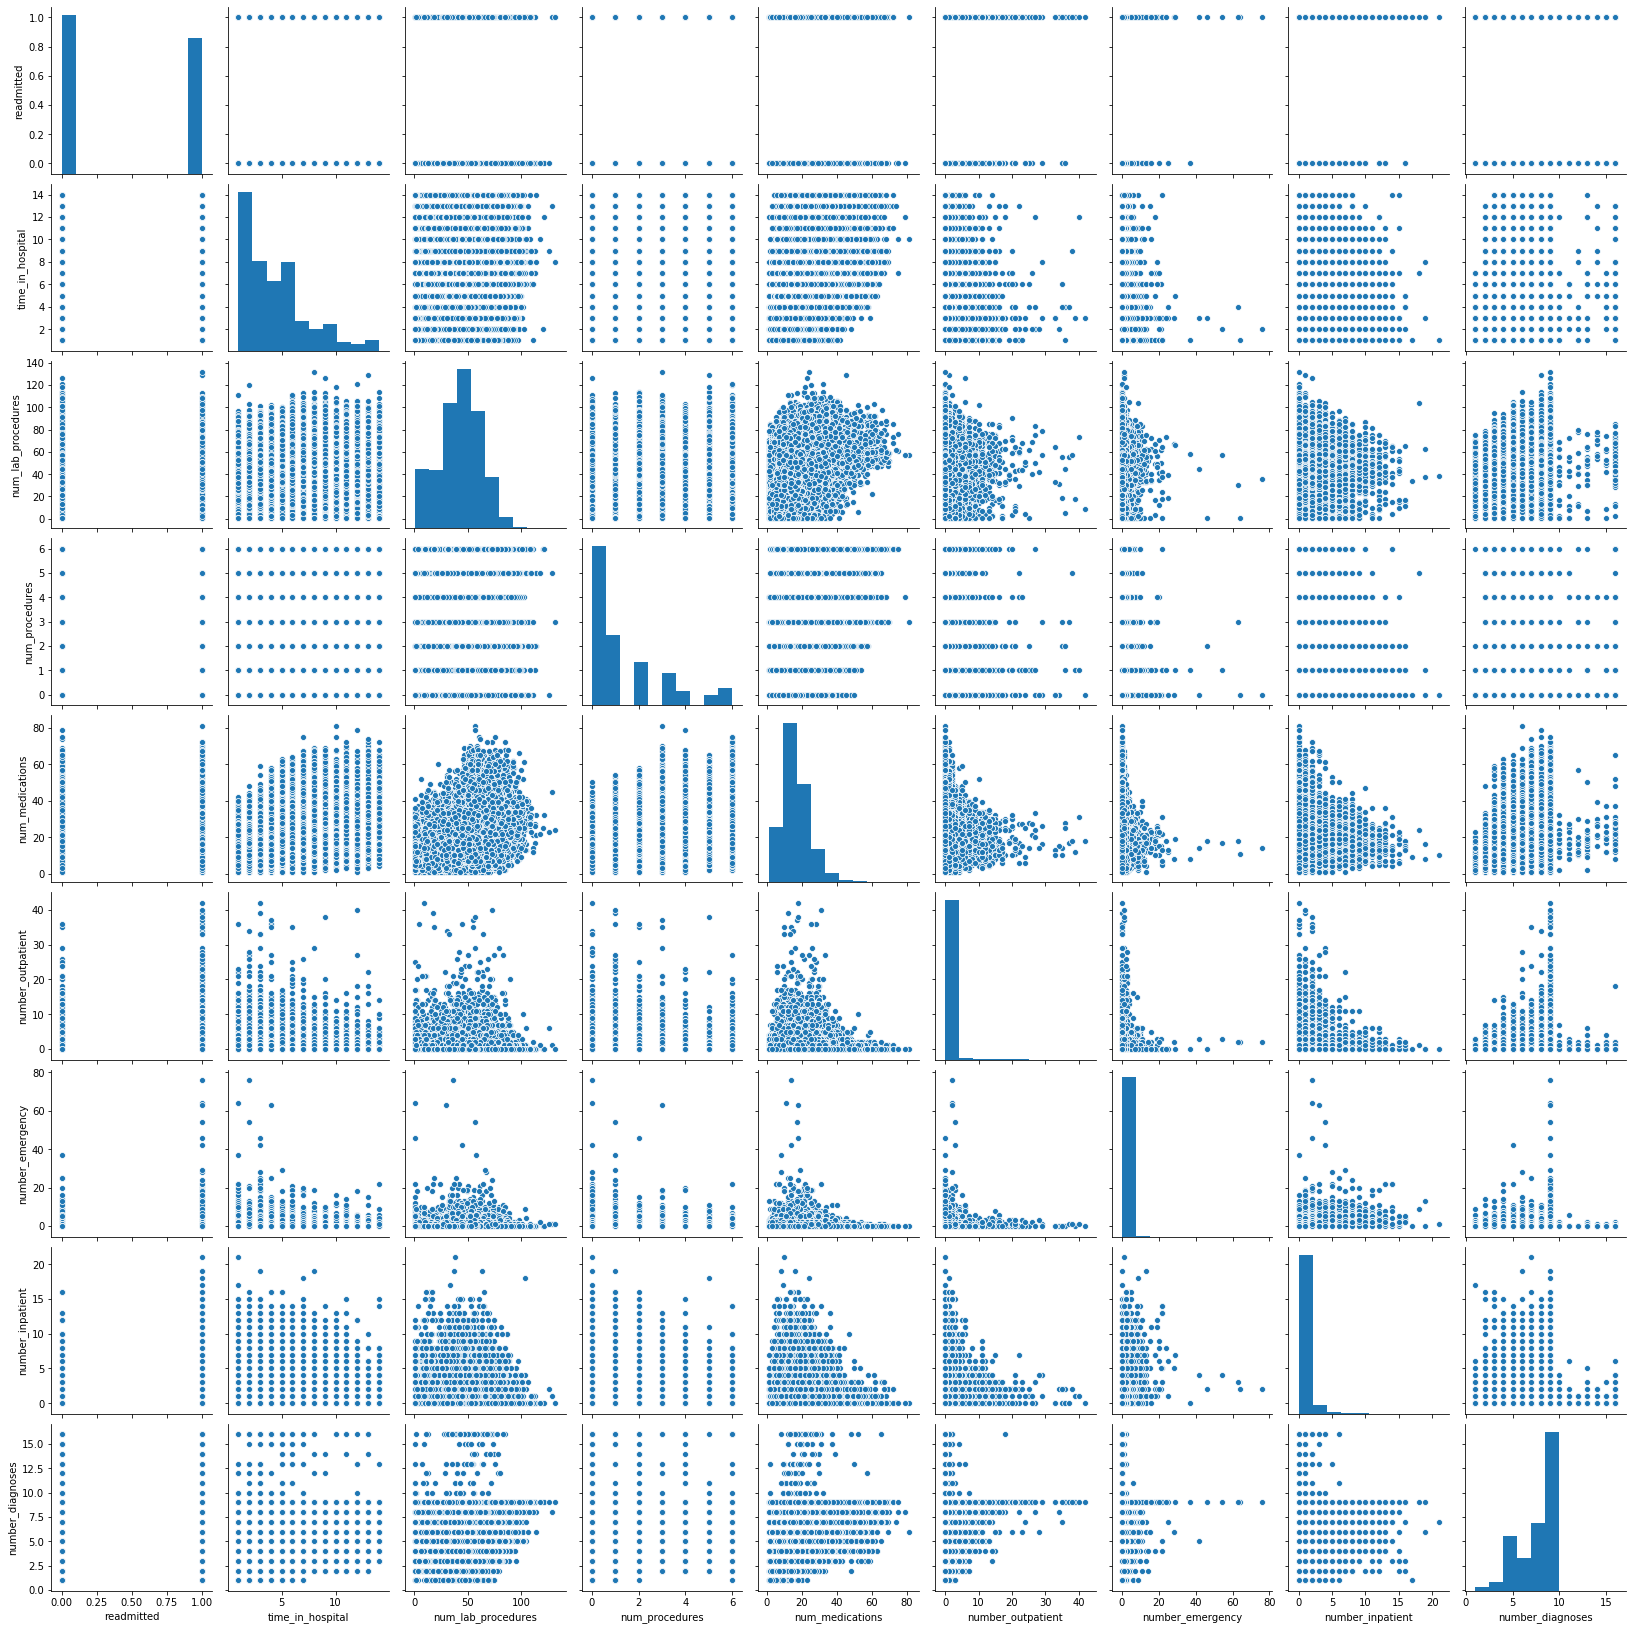

In [18]:
ax = sns.pairplot(df[num_cols])

The above pair plot shows that there is not much multi-collinearity between features. 

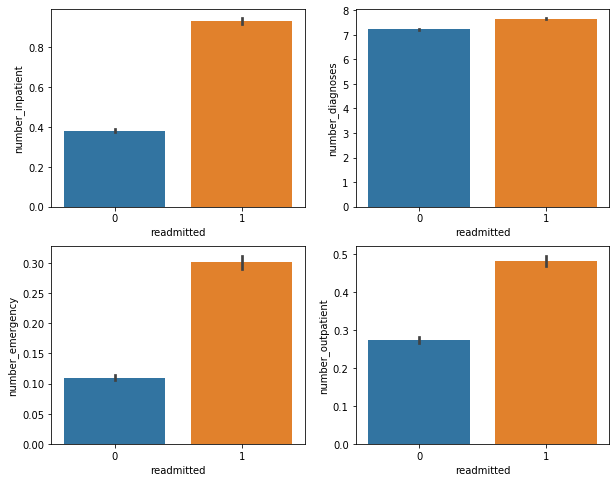

In [19]:
fig, ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)
plt.rcParams["axes.labelsize"] = 10
sns.barplot(x = df['readmitted'], y = df['number_inpatient'], ax=ax[0][0])
sns.barplot(x = df['readmitted'], y = df['number_diagnoses'], ax=ax[0][1])
sns.barplot(x = df['readmitted'], y = df['number_emergency'], ax=ax[1][0])
sns.barplot(x = df['readmitted'], y = df['number_outpatient'], ax=ax[1][1])

### Time in hospital and readmission

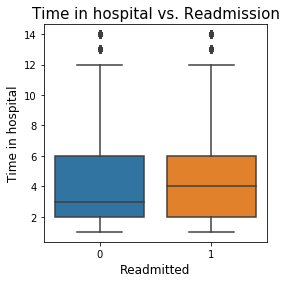

In [20]:
fig = plt.figure(figsize=(4,4))
g = sns.boxplot(x = df['readmitted'], y = df['time_in_hospital'])
g.set_title("Time in hospital vs. Readmission", fontsize=15)
g.set_xlabel("Readmitted",fontsize=12)
g.set_ylabel("Time in hospital",fontsize=12)
g.tick_params(labelsize=10)

The median time spent in hospital for readmitted patients is higher than non-readmitted patients. Also, we notice that the data is skewed.

## Categorical Features

### Age

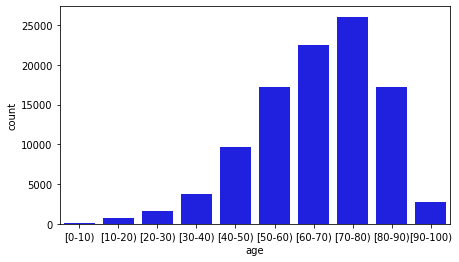

In [21]:
fig, ax = plt.subplots(figsize=(7,4))
sns.countplot(x="age", data=df, color='b')

The age of patients concentrates on the range of 50 to 90. It is categorical value now and will be ranked later.

### Age and readmission

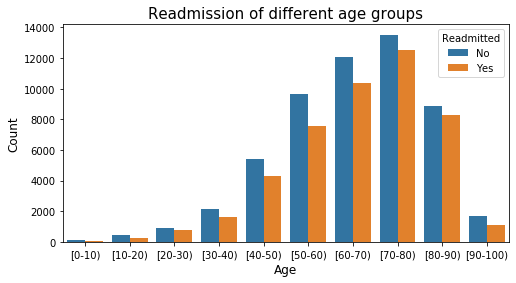

In [22]:
fig = plt.figure(figsize=(8,4))
g = sns.countplot(x= df['age'], hue = df['readmitted'])
g.axes.set_title("Readmission of different age groups",fontsize=15)
g.set_xlabel("Age",fontsize=12)
g.set_ylabel("Count",fontsize=12)
g.tick_params(labelsize=10)
g.legend(title = 'Readmitted', labels = ('No', 'Yes'))

For patients with all different ages, the non-readmitted cases are always greater than readmitted cases.

### Ethnicity and readmission

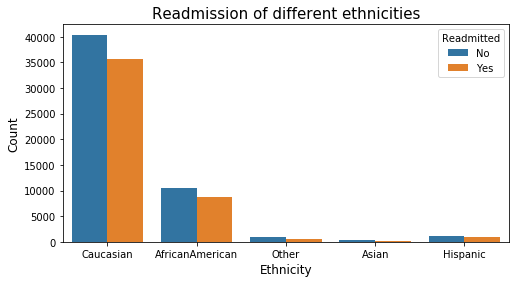

In [23]:
fig = plt.figure(figsize=(8,4))
g = sns.countplot(x = df['race'], hue = df['readmitted'])
g.axes.set_title("Readmission of different ethnicities",fontsize=15)
g.set_xlabel("Ethnicity",fontsize=12)
g.set_ylabel("Count",fontsize=12)
g.tick_params(labelsize=10)
g.legend(title = 'Readmitted', labels = ('No', 'Yes'))

### Gender and readmission

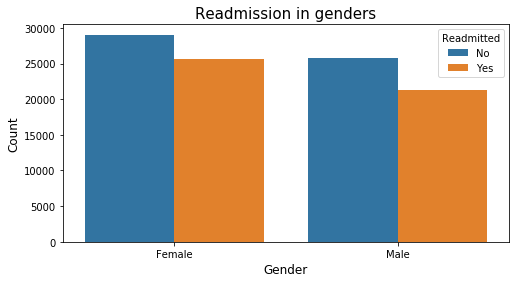

In [24]:
fig = plt.figure(figsize=(8,4))
g = sns.countplot(x = df['gender'], hue = df['readmitted'])
g.axes.set_title("Readmission in genders",fontsize=15)
g.set_xlabel("Gender",fontsize=12)
g.set_ylabel("Count",fontsize=12)
g.tick_params(labelsize=10)
g.legend(title = 'Readmitted', labels = ('No', 'Yes'))

There is no visual trend of readmission rate between different ethnicities or different genders from above plots.

### More categorical features

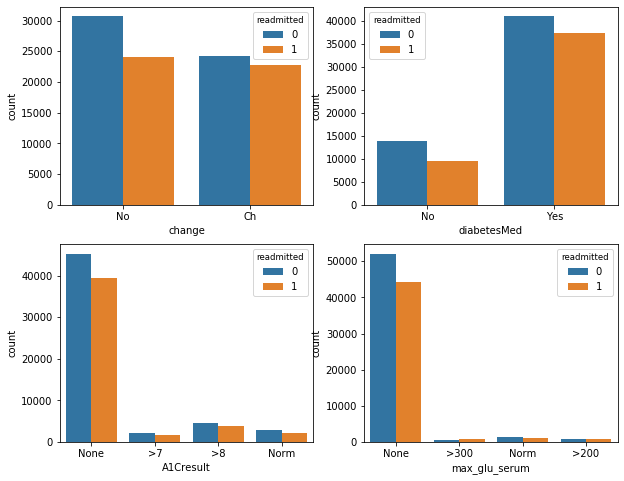

In [25]:
fig, ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)
sns.countplot(x=df["change"], hue = df['readmitted'], ax=ax[0][0])
sns.countplot(x=df["diabetesMed"], hue = df['readmitted'], ax=ax[0][1])
sns.countplot(x=df['A1Cresult'], hue = df['readmitted'], ax=ax[1][0])
sns.countplot(x=df['max_glu_serum'], hue = df['readmitted'], ax=ax[1][1])

From above exploration, we did not find any particular feature that has a large effect on the readmission.

# 3 Feature Engineering

## 3.1 Missing values
After dropping three features that with a large portion of missing values, there are still three features with a small numbers of missing values. They are *‘race’*, *'diag_1'*, *'diag_2'* and *'diag_3'*.

In [26]:
missing_count = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
missing_percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
pd.concat([missing_count, missing_percentage], axis=1, keys=['missing_count','missing_percentage'])

,missing_count,missing_percentage
race,2273,2.23
diag_3,1423,1.40
diag_2,358,0.35
diag_1,21,0.02
gender,3,NaN


**Gender**: There are only 3 missing values in column of gender. These 3 rows are removed.

**Race**: There are a fair amount of missing values in race. We can create a new category which is 'Unknown'.

The *'diag_1'*, *'diag_2'* and *'diag_3'* features have too many unique values. They are grouped first and the missing values are dealt later.

In [27]:
# Dropping rows with missing gender
df=df[df['gender'].notnull()]
df['race'] = df['race'].fillna('Unknown')

## 3.2 Creating new features

### Number of total hospital visits

In [28]:
df['number_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

## 3.3 Encoding features
The three diagnoses have over 700 unique values each. We can classify them into larger categories based on the ICD9 code.

### Diagnoses

In [29]:
# Mapping each ICD9 code with a disease category
def ICD9(diagnoses):
    diagnoses_1 = diagnoses.copy()
    dict_icd9 = {'Infectious':(1, 139),
                'Neoplasmic':(140,239),
                'Hormonal':(240, 279),
                'Blood':(280,289),
                'Mental':(290,319),
                'Nervous':(320,359),
                'Sensory':(360,389),
                'Circulatory':(390,459),
                'Respiratory':(460,519),
                'Digestive':(520,579),
                'Genitourinary':(580,629),
                'Childbirth':(630,679),
                'Dermatological':(680,709),
                'Musculoskeletal':(710,739),
                'Congenital':(740,759),
                'Perinatal':(760,779),
                'Miscellaneous':(780,799),
                'Injury':(800,999)}
    for i, diagnosis in enumerate(diagnoses):
        if (str(diagnoses[i])[0] == 'E') or (str(diagnoses[i])[0] == 'V'):
            diagnoses_1[i] = 'Accidental'
        elif (str(diagnoses[i]).lower() == 'nan'):
            diagnoses_1[i] = 'NaN'
        else:
            for key, icd9_range in dict_icd9.items():
                if (int(float(diagnoses[i])) >= icd9_range[0]) and (int(float(diagnoses[i])) <= icd9_range[1]):
                    diagnoses_1[i] = key
    return diagnoses_1

In [30]:
df['diag_1'] = ICD9(df.diag_1.values)
df['diag_2'] = ICD9(df.diag_2.values)
df['diag_3'] = ICD9(df.diag_3.values)

# Fill up missing values with mode of each diagnosis
df['diag_1'].replace({'NaN':df['diag_1'].mode()[0]},inplace=True)
df['diag_2'].replace({'NaN':df['diag_2'].mode()[0]},inplace=True)
df['diag_3'].replace({'NaN':df['diag_3'].mode()[0]},inplace=True)

### admission_source_id
There are 17 unique values in this column. We can combine them into two levels.

In [31]:
df['admission_source_id'] = pd.Series(['Emergency' if val == 7 else 'Referral' if val in [1,2,3] else 'Other' 
                                              for val in df['admission_source_id']], index=df.index)

### admission_type_id
This column contains 8 levels. *'Emergency'*, *'Urgent'* and *'Trauma center'* can be combined due to they are all non-elective cases. The rest several types are combined together.

In [32]:
df['admission_type_id'] = pd.Series(['Emergency' if val in [1,2,7] else 'Other' 
                                              for val in df['admission_type_id']], index=df.index)

### Age
The age feature given in the dataset is not a continous variable, instead it is represented by a 10-year range. Here, age is converted to the middle value of a certain range.

In [33]:
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
df['age'] = df.age.map(age_dict)

### Different medications
For each medication, there are four different categories. Here, *'Steady'*, *'Up'* and *'Down'* are combined together.

In [34]:
medications = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',
               'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
               'miglitol','troglitazone','tolazamide','insulin','glyburide-metformin',
               'glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
               'metformin-pioglitazone']
for med in medications:
    df[med] = df[med].replace('No', 0)
    df[med] = df[med].replace('Steady', 1)
    df[med] = df[med].replace('Up', 1)
    df[med] = df[med].replace('Down', 1)

### Encoding categorical features

In [35]:
df = pd.get_dummies(df, drop_first=True).reset_index(drop=True)

## 3.4 Feature scaling

In [36]:
num_features = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [37]:
df.drop('patient_nbr', axis=1, inplace=True)

# 4 Training models

## 4.1 Split train and test data sets

In [38]:
X = df.drop(['readmitted'], axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
print('Shape of X_train, X_test', X_train.shape, X_test.shape)

Shape of X_train, X_test (81410, 100) (20353, 100)


## 4.2 Models

Here, four different models are built, *Logistic Regression*, *Support Vector Machine (SVM)*, *Random Forest* and *XGBoost*. Logistic regression is a good start for classification problems. It is linear, simple and efficient. SVM with different kernels can be very powerful. And two tree-based ensemble methods, Random Forest and XGBoost, have proven to be reliable.

For each model, *GridSearchCV* was used to find the optimal hyperparameters by grid searching along with cross validation. To evaluate the performance of each model, the best estimator found from grid searching were applied on predicting the test set.

### Logistic Regression

In [39]:
params_lr = {'penalty' : ['l1', 'l2'], 'C' : [10, 1.0, 0.1, 0.01, 0.001]}
lr = LogisticRegression(random_state=42)
gs_lr = GridSearchCV(estimator=lr, param_grid=params_lr, scoring='roc_auc', cv=10)
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10, 1.0, 0.1, 0.01, 0.001],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [40]:
print(gs_lr.best_score_)
print(gs_lr.best_params_)
lr_cv = gs_lr.best_estimator_

0.6638334206216024
{'C': 0.01, 'penalty': 'l2'}


#### Feature Importance

In [41]:
coefs=gs_lr.best_estimator_.coef_[0]
sorted_index = np.argsort(coefs)[::-1]
#get the index of the top-15 features
top_15 = sorted_index[:15]
top_features = X_train.columns[top_15]
top_coefs = coefs[top_15]
fea_lr = pd.DataFrame({'Feature':top_features, 'Coefficient':top_coefs})
fea_lr

,Feature,Coefficient
0,diabetesMed_Yes,0.282221
1,number_inpatient,0.253009
2,diag_2_Dermatological,0.237966
3,diag_1_Hormonal,0.172352
4,acarbose,0.165956
5,number_visits,0.161344
6,number_diagnoses,0.142799
7,diag_3_Dermatological,0.135019
8,admission_type_id_Other,0.130026
9,diag_1_Circulatory,0.128090


From the coefficients of Logistic Regression, the most important features are: diabetesMed, diag_2 (one category), number_inpatient, number_visits and diag_1 (one category).

### K Nearest Neighbors (KNN)
KNN is easy to run, however, it can not give us the information about feature importances.

In [42]:
params_knn = {'n_neighbors':[50,80,100,150]}
knn = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator=knn, param_grid=params_knn, scoring='roc_auc',cv=10)
gs_knn.fit(X_train, y_train)

print(gs_knn.best_score_)
print(gs_knn.best_params_)
knn_cv = gs_knn.best_estimator_

0.6859979764053279
{'n_neighbors': 150}


### Random Forest

In [43]:
params_rf = {'n_estimators':[200,500,800], 
             'max_depth':range(5,8,1), 
             'min_samples_split':[2, 5, 8]}
rf = RandomForestClassifier(random_state=42,n_jobs=-1)
gs_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='roc_auc',cv=10)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                   

In [44]:
print(gs_rf.best_score_)
print(gs_rf.best_params_)
rf_cv = gs_rf.best_estimator_

0.6759866817214254
{'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 800}


#### Feature Importance

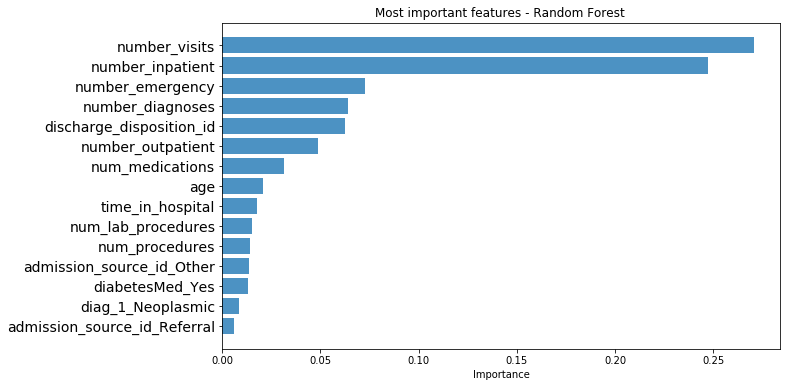

In [45]:
feature_names = X_train.columns
importances = rf_cv.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,importances)], columns=["Feature", "Importance"]).nlargest(15, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

From the above plot, we can find that the most important features are: number_visits, number_inpatient, number_emergency, number_diagnoses and number_outpatient.

### XGBoost

In [46]:
params_xgb = {'n_estimators':range(400,1000,200), 
              'max_depth':range(6,9,1),
              'min_child_weight':range(1,3,1)}
xgb = XGBClassifier(learning_rate=0.01,n_estimators=1000,
                    gamma=0.1,subsample=0.9,reg_alpha=1,n_jobs=-1,seed=42)
gs_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, scoring='roc_auc',cv=10)
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0.1,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     random_state=None, reg_alpha=1,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=42, subsample=0.9, tree_method=None,
                                     validate_parameters=N

In [47]:
print(gs_xgb.best_score_)
print(gs_xgb.best_params_)
xgb_cv = gs_xgb.best_estimator_

0.6999264591991811
{'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 800}


#### Early Stopping

For XGBoost, to avoid overfitting, early stopping was implemented. The training process will be
terminated if the AUC hasn't improved in 10 rounds. The AUC of both train and test data were
recorded during this process, and then plotted.

In [48]:
%time

# Reload the best estimator obtained from grid search
# Specify the metric to be auc
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', gamma=0.1, learning_rate=0.01, 
                          max_delta_step=0, max_depth=6, min_child_weight=2, n_estimators=600, 
                          n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=1, 
                          reg_lambda=1, scale_pos_weight=1, seed=42, eval_metric='auc')

# Specify evaluation set to be both train and test
eval_set=[(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=200)

Wall time: 0 ns
[0]	validation_0-auc:0.67819	validation_1-auc:0.67601
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[200]	validation_0-auc:0.69934	validation_1-auc:0.69370
[400]	validation_0-auc:0.71201	validation_1-auc:0.70031
[599]	validation_0-auc:0.72027	validation_1-auc:0.70210


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic', random_state=42,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

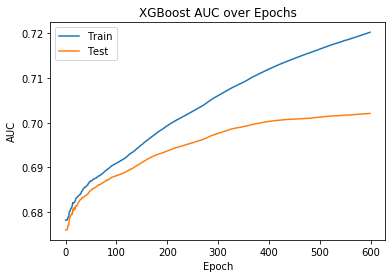

In [49]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['auc'])
fig,ax = plt.subplots(figsize=(6,4))
x_axis = range(0, epochs)
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.set(xlabel='Epoch', ylabel='AUC')
ax.legend()
ax.set_title('XGBoost AUC over Epochs')
plt.show()

XGBoost training process was terminated at 600th epoch. Even though continuing traing can improve performance on training set, it will cause overfitting on test set.

#### Feature Importance

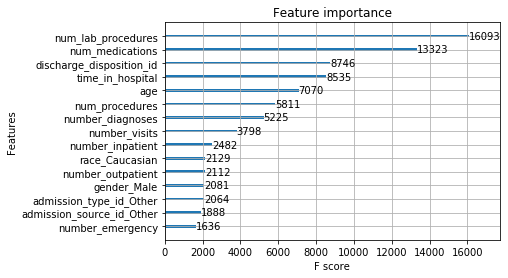

In [50]:
plot_importance(xgb_cv, max_num_features=15)

From the above plot, we can find that the most important features are: number_lab_procedures, num_medications, time_in_hospital, age and num_procedures.

# 5 Evaluating model performance

The problem we are dealing here is binary classification. Different metrics, accuracy, recall, precision and also AUC score are compared among models.

In [51]:
lr_model = lr_cv.fit(X_train, y_train)
knn_model = knn_cv.fit(X_train, y_train)
rf_model = rf_cv.fit(X_train, y_train)
xgb_model = xgb_model.fit(X_train, y_train)

In [52]:
models = [lr_model, knn_model, rf_model, xgb_model]
plot_table = pd.DataFrame(columns=['model', 'fpr','tpr','auc'])
result_table = pd.DataFrame(columns=['Model', 'Accuracy','Recall','Precision','AUC'])
model_name = ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost']

for i, model in enumerate(models):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob[:,1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
    plot_table = plot_table.append({'model':model_name[i],
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc}, ignore_index=True)
    result_table = result_table.append({'Model':model_name[i],
                                       'Accuracy':accuracy,
                                       'Recall':recall,
                                       'Precision':precision,
                                       'AUC':auc}, ignore_index=True)

plot_table.set_index('model', inplace=True)
result_table

,Model,Accuracy,Recall,Precision,AUC
0,Logistic Regression,0.626787,0.436543,0.635782,0.665218
1,K-Nearest Neighbors,0.639414,0.489129,0.639994,0.687970
2,Random Forest,0.638432,0.505623,0.632503,0.683512
3,XGBoost,0.648602,0.527364,0.642568,0.702096


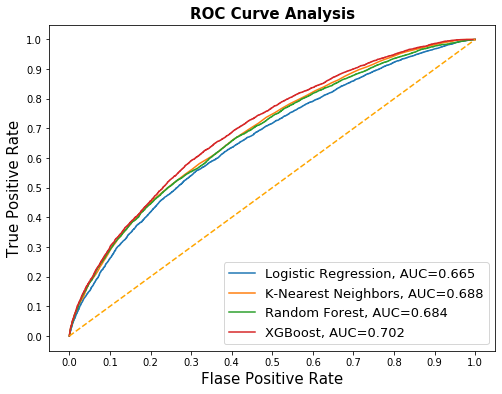

In [53]:
fig = plt.figure(figsize=(8,6))

for i in plot_table.index:
    plt.plot(plot_table.loc[i]['fpr'], 
             plot_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, plot_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

From above table and the ROC curves, we can conclude that XGBoost outperforms other models on both accuracy and AUC score. Simple model, KNN, also gives us decent prediction. Depends on the real-life situation, if we want a classifier that easy to run and easy to interpret, KNN can be a good choice, though, we can not get information of feature importance from it. 

If we are seeking higher accuracy and don't mind the complexity, XGBoost will be the final classifier. 

# 6 Summary

In this assignment, Exploratory Data Analysis was performed first to get familiar with the data and also the relationship between features. Then feature engineering was conducted. The missing values were dealt with and one new features was created, which is number of total hospital visits. A lot of features in this dataset have a large number of unique values. For example, each diagnosis has over 700 unique values. To make better use of these features and reduce computational complexity, they were encoded into more general categories (18 categories). 

The data set was separated in to training and testing sets with a 80/20 split. Four different models were included here, Logistic Regression, KNN, Random Forest and XGBoost. For each of them, hyperparameters were tuned using grid search along with 10-fold cross validation. The final model is the best estimator obtained from GridSearchCV. Specifically, to avoid overfitting using XGBoost, Early Stopping was applied once the performance on test set stopped increasing.

XGBoost outperforms other models in both accuracy (0.649) and AUC score (0.702). Simple classifier, KNN, also gives us decent predictions (Accuracy 0.639). Depends on the real-life situation, if we want to keep the model simple and easy to interpret, it can be good a choice. I am assuming that accuracy is more important in this case, so XGBoost will be the final classifier. 

Combining the feature importance analysis of different models, the most important features that can effect readmission are: Number of medications,  number of visits, number of inpatient, number of emergency, number of lab procedure, time in hospital, age and discharge disposition.

# 7 Future Work

Due to the limitation of time, there are a few more ideas that I am not able to explore.

- Fine tuning hyperparameters can improve the performance. The best estimator of XGBoost is using the largest n_estimators and max_depth. If we increase these two hyperparameters, the model becomes more complex but could give us better prediction.


- The numbers of two predicted classes (readmitted or not) is a little bit unbalanced, though they are close enough. We can resample the data and make the two classes balance using tools such as SMOTE.


- Feature engineering can be improved in several ways. First, more features can be created based on understanding of the dataset. Encoding on some features should be more detailed. For example, the *discharge_disposition_id* had 29 categories initially and was combined into only two categories in my first version, discharged to home or not. It can be a very important factor that can affect the admission. Then for the second run, I left it the way it was without any encoding. The accuracy increased about 1% on average for different models. A deeper understanding on the different types of discharge will be helpful to categories them in a better way. Also, for different types of medications used, I grouped into 'yes' or 'no'. However, the dose change (up or down) can have an effect.


- Different types of models, such as Neural Networks, can be applied on this data. It usually gives higher accuracy. However, Neural Networks lacks interpretability.


- Here, a threshold of 0.5 was used to label the prediction. It can be a good approach which is to decrease the threshold for better sensitivity.